# Convolutional Neural Networks
### Augmentation

Augmentation is kind of cheeting...we use dataset for training a model with images
that were rotated, scaled...etc...so our model will be able to classify a rotated, shifted, or bigger image


https://classroom.udacity.com/courses/ud188/lessons/b1e148af-0beb-464e-a389-9ae293cb1dcd/concepts/c5e2d73f-b4de-4573-af5c-d59582f43edd



http://localhost:8888/notebooks/Documents/olga_data_science_udacity_deep_learning_pytorch/convolutional-neural-networks/cifar-cnn/cifar10_cnn_augmentation.ipynb


---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.

The images in this database are small color images that fall into one of ten classes; some example images are pictured below. Each image is 32 by 32 in color.

<img src='data/cifar_data.png' width=70% height=70% />

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [1]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


---
## Load and Augment the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html).
Data Augmentation also prevents overfitting.

#### TODO: Look at the [transformation documentation](https://pytorch.org/docs/stable/torchvision/transforms.html); add more augmentation transforms, and see how your model performs.

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.

In [6]:
from torchvision import datasets
#library for augmentation
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
#and perform augmentation
#random horizontal flip, and random rotation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # randomly flip along horizontal axis
    transforms.RandomRotation(10), #randomly rotates an image
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the 10 image classes that I am loading in
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


### Visualize a Batch of Training Data

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    #convert from tensor image type to image for visualization
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

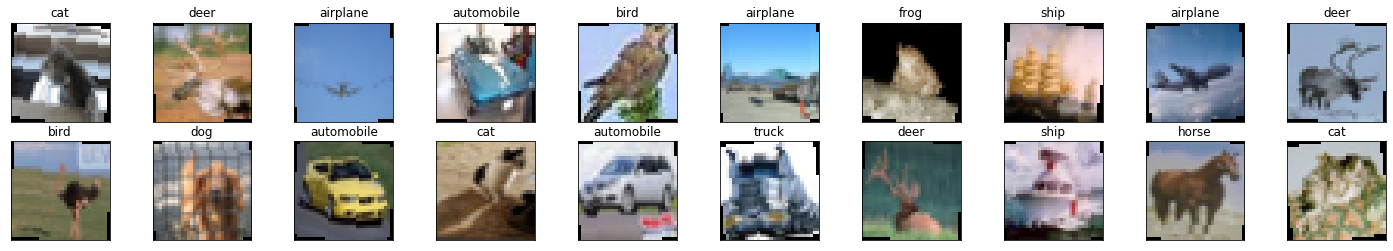

In [4]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

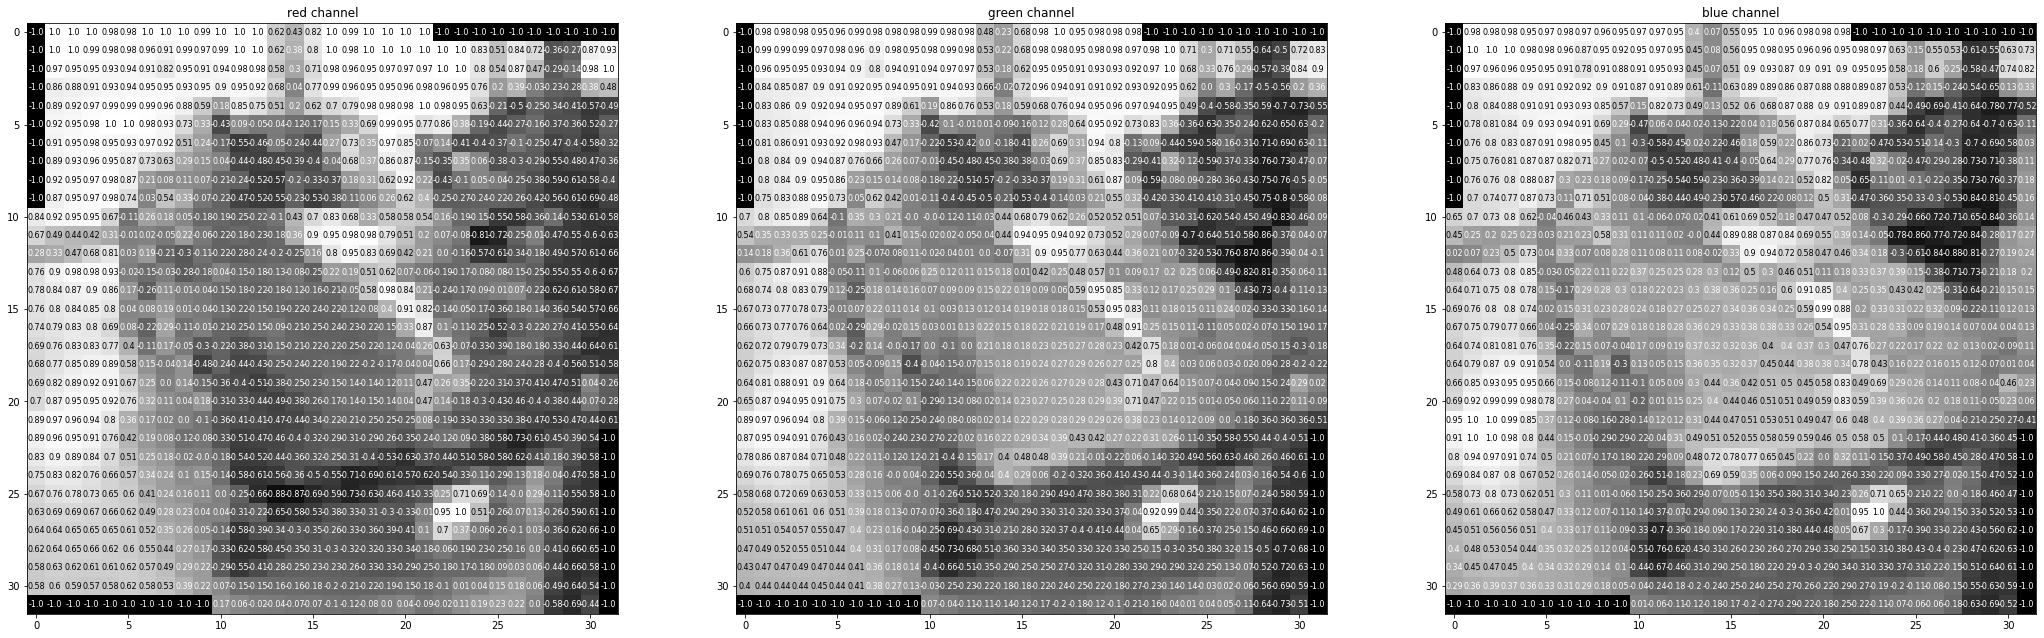

In [5]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below and in the code, and you've been given starter code with one convolutional and one maxpooling layer.

<img src='data/2_layer_conv.png' height=50% width=50% />

#### TODO: Define a model with multiple convolutional layers, and define the feedforward network behavior.

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        #depth of 3 for RGB colored images size 32x32
        #should output a convolutional layer with a depth of 16
        #filter is 3 by 3
        # 1 pixel padding on a border
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # max pooling layer
        # (kernel size =2 , stride_size=2)
        # any input will donwsample it x y dimensions by a factor of 2
        #convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25), to avoid overfitting drop 25%
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        #flatten and apply fully-connected layer for producing the desired
        #number of class score outputs
        return x

# create a complete CNN
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

#### TODO: Define the loss and optimizer and see how these choices change the loss over time.

In [8]:
import torch.optim as optim

# specify loss function  
#for classification use CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [9]:
# number of epochs to train the model
n_epochs = 30 # you may increase this number to train a final model

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.711297 	Validation Loss: 0.367172
Validation loss decreased (inf --> 0.367172).  Saving model ...
Epoch: 2 	Training Loss: 1.364266 	Validation Loss: 0.307853
Validation loss decreased (0.367172 --> 0.307853).  Saving model ...
Epoch: 3 	Training Loss: 1.216572 	Validation Loss: 0.281517
Validation loss decreased (0.307853 --> 0.281517).  Saving model ...
Epoch: 4 	Training Loss: 1.123140 	Validation Loss: 0.261320
Validation loss decreased (0.281517 --> 0.261320).  Saving model ...
Epoch: 5 	Training Loss: 1.054923 	Validation Loss: 0.248851
Validation loss decreased (0.261320 --> 0.248851).  Saving model ...
Epoch: 6 	Training Loss: 1.001749 	Validation Loss: 0.233667
Validation loss decreased (0.248851 --> 0.233667).  Saving model ...
Epoch: 7 	Training Loss: 0.954489 	Validation Loss: 0.223692
Validation loss decreased (0.233667 --> 0.223692).  Saving model ...
Epoch: 8 	Training Loss: 0.918480 	Validation Loss: 0.215823
Validation loss decreased (0.22369

###  Load the Model with the Lowest Validation Loss
should be augmented, different file name for a model, but we are overwriting, so that's ok


In [10]:
model.load_state_dict(torch.load('model_cifar.pt'))

<All keys matched successfully>

---
## Test the Trained Network

Test your trained model on previously unseen data! A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

In [11]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.693088

Test Accuracy of airplane: 82% (822/1000)
Test Accuracy of automobile: 90% (902/1000)
Test Accuracy of  bird: 54% (547/1000)
Test Accuracy of   cat: 62% (621/1000)
Test Accuracy of  deer: 73% (738/1000)
Test Accuracy of   dog: 63% (634/1000)
Test Accuracy of  frog: 87% (870/1000)
Test Accuracy of horse: 82% (829/1000)
Test Accuracy of  ship: 81% (813/1000)
Test Accuracy of truck: 81% (810/1000)

Test Accuracy (Overall): 75% (7586/10000)


Slight improvement in comparison with data without augmentation

Test Accuracy of airplane: 81% (812/1000)
Test Accuracy of automobile: 88% (889/1000)
Test Accuracy of  bird: 61% (614/1000)
Test Accuracy of   cat: 52% (527/1000)
Test Accuracy of  deer: 72% (722/1000)
Test Accuracy of   dog: 69% (699/1000)
Test Accuracy of  frog: 83% (835/1000)
Test Accuracy of horse: 80% (808/1000)
Test Accuracy of  ship: 83% (832/1000)
Test Accuracy of truck: 85% (851/1000)


### Question: What are your model's weaknesses and how might they be improved?

**Answer**: This model seems to do best on vehicles rather than animals. For example, it does best on the automobile class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

### Visualize Sample Test Results

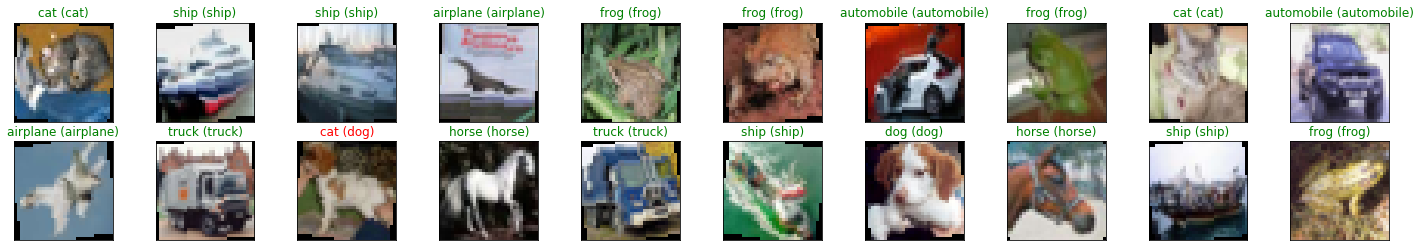

In [12]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

### Visualiazing CNN

(REALLY COOL) Optional Resources
If you would like to know more about interpreting CNNs and convolutional layers in particular, you are encouraged to check out these resources:

Here's a section from the Stanford's CS231n course on visualizing what CNNs learn.
http://cs231n.github.io/understanding-cnn/


Check out this demonstration of a cool OpenFrameworks app that visualizes CNNs in real-time, from user-supplied video!
https://aiexperiments.withgoogle.com/what-neural-nets-see


Here's a demonstration of another visualization tool for CNNs. If you'd like to learn more about how these visualizations are made, check out this video.
https://www.youtube.com/watch?v=AgkfIQ4IGaM&t=78s
https://www.youtube.com/watch?v=ghEmQSxT6tw&t=5s



Read this Keras blog post on visualizing how CNNs see the world.
https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
In this post, you can find an accessible introduction to Deep Dreams, along with code for writing your own deep dreams in Keras. When you've read that:

Also check out this music video 
https://www.youtube.com/watch?v=XatXy6ZhKZw
that makes use of Deep Dreams (look at 3:15-3:40)!
Create your own Deep Dreams (without writing any code!) using this website.
https://deepdreamgenerator.com/
If you'd like to read more about interpretability of CNNs:

Here's an article 
https://blog.openai.com/adversarial-example-research/
that details some dangers from using deep learning models (that are not yet interpretable) in real-world applications.
There's a lot of active research in this area. These authors recently made a step in the right direction.
https://arxiv.org/abs/1611.03530


Visualizing CNNs
Let’s look at an example CNN to see how it works in action.

The CNN we will look at is trained on ImageNet as described in this paper by Zeiler and Fergus.
hhttps://cs.nyu.edu/~fergus/papers/zeilerECCV2014.pdf
In the images below (from the same paper), we’ll see what each layer in this network detects and see how each layer detects more and more complex ideas.


Example patterns that cause activations in the first layer of the network. These range from simple diagonal lines (top left) to green blobs (bottom middle).

The images above are from Matthew Zeiler and Rob Fergus' deep visualization toolbox, which lets us visualize what each layer in a CNN focuses on.

Each image in the above grid represents a pattern that causes the neurons in the first layer to activate - in other words, they are patterns that the first layer recognizes. The top left image shows a -45 degree line, while the middle top square shows a +45 degree line. These squares are shown below again for reference.


As visualized here, the first layer of the CNN can recognize -45 degree lines.


The first layer of the CNN is also able to recognize +45 degree lines, like the one above.

Let's now see some example images that cause such activations. The below grid of images all activated the -45 degree line. Notice how they are all selected despite the fact that they have different colors, gradients, and patterns.


Example patches that activate the -45 degree line detector in the first layer.

So, the first layer of our CNN clearly picks out very simple shapes and patterns like lines and blobs.

Layer 2

A visualization of the second layer in the CNN. Notice how we are picking up more complex ideas like circles and stripes. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The second layer of the CNN captures complex ideas.

As you see in the image above, the second layer of the CNN recognizes circles (second row, second column), stripes (first row, second column), and rectangles (bottom right).

The CNN learns to do this on its own. There is no special instruction for the CNN to focus on more complex objects in deeper layers. That's just how it normally works out when you feed training data into a CNN.

Layer 3

A visualization of the third layer in the CNN. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The third layer picks out complex combinations of features from the second layer. These include things like grids, and honeycombs (top left), wheels (second row, second column), and even faces (third row, third column).

We'll skip layer 4, which continues this progression, and jump right to the fifth and final layer of this CNN.

Layer 5

A visualization of the fifth and final layer of the CNN. The gray grid on the left represents how this layer of the CNN activates (or "what it sees") based on the corresponding images from the grid on the right.

The last layer picks out the highest order ideas that we care about for classification, like dog faces, bird faces, and bicycles.